# **Titanic_Classification**

**Algorithm which tells whether the person will be save from sinking or not**

Titanic data-set : The Titanic dataset is a famous dataset in the field of machine learning and data science. It contains information about the passengers aboard the Titanic, including whether they survived or not. The goal is to predict whether a given passenger survived the disaster based on various features.
The dataset for this experiment is freely available on the Kaggle website. Download the dataset from this link https://www.kaggle.com/competitions/titanic/data?select=train.csv. Once the dataset is downloaded it is divided into three CSV files gender submission.csv train.csv and test.csv

**Purpose:**
   Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Steps Involved:**


1.  Preparation
2.   Exploratory Data Analysis
3. Feature Engineering
4.  Model Building






....

importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Loading dataset

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

display(df_train.head())
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Checking null values

In [3]:
pd.DataFrame(data = [df_train.isna().sum()/df_train.shape[0]*100, df_test.isna().sum()/df_test.shape[0]*100], index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


Checking duplicate data

In [4]:
print(f"Train data has {df_train.duplicated().sum()} duplicated data")
print(f"Test data has {df_test.duplicated().sum()} duplicated data")

Train data has 0 duplicated data
Test data has 0 duplicated data


Checking Dataset Information

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
num_var = ["SibSp", "Parch", "Age", "Fare"]
cat_var = ["Sex", "Embarked", "Pclass"]
target = "Survived"

In [7]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()

def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df_train[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=df_train, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

Checking Target Distribution

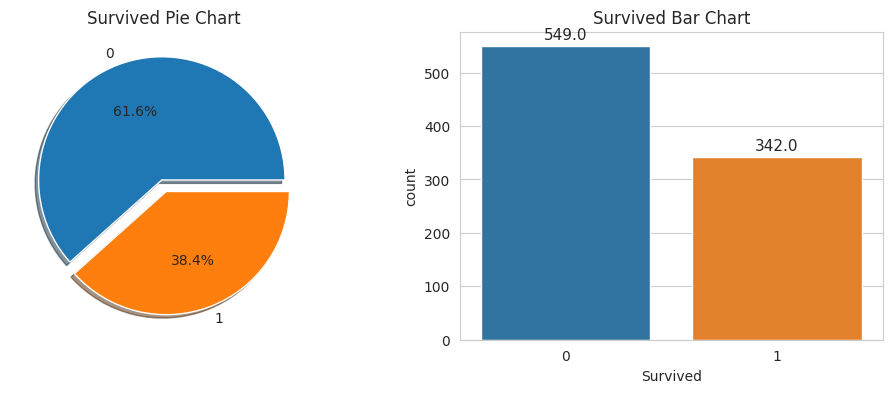

In [8]:
cat_dist(df_train, "Survived")

Numerical

In [9]:
df_train[num_var].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,714.000000,891.000000
mean,0.523008,0.381594,29.699118,32.204208
std,1.102743,0.806057,14.526497,49.693429
min,0.000000,0.000000,0.420000,0.000000
25%,0.000000,0.000000,20.125000,7.910400
50%,0.000000,0.000000,28.000000,14.454200
75%,1.000000,0.000000,38.000000,31.000000
max,8.000000,6.000000,80.000000,512.329200


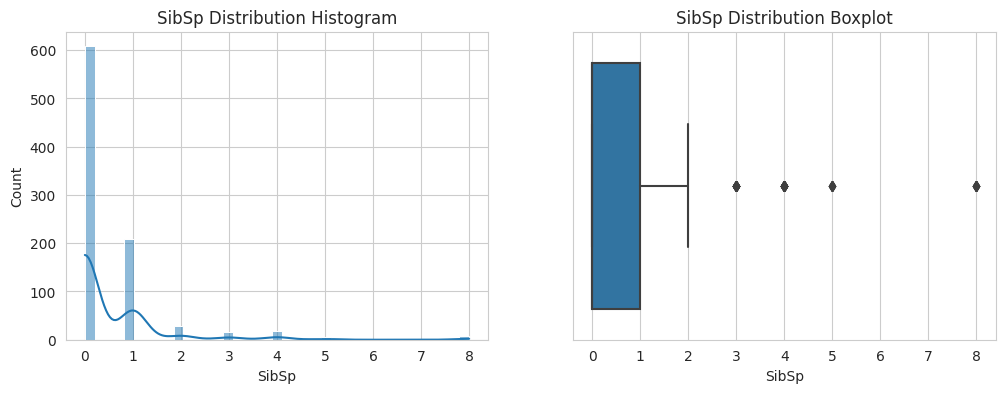

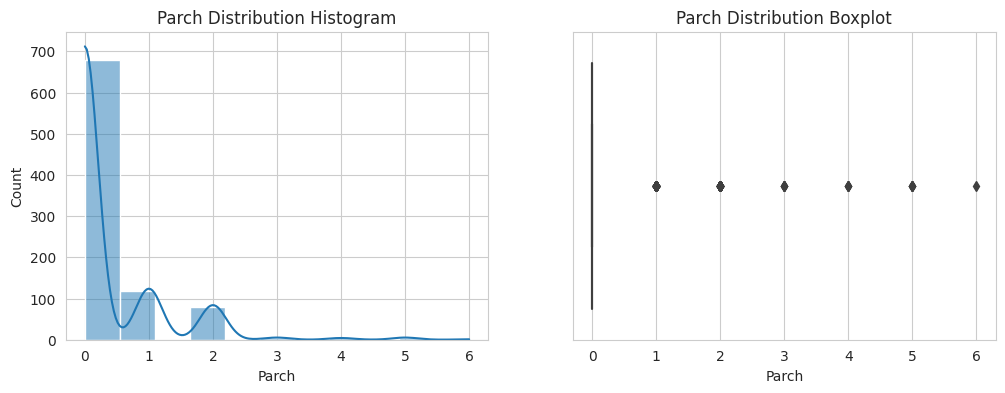

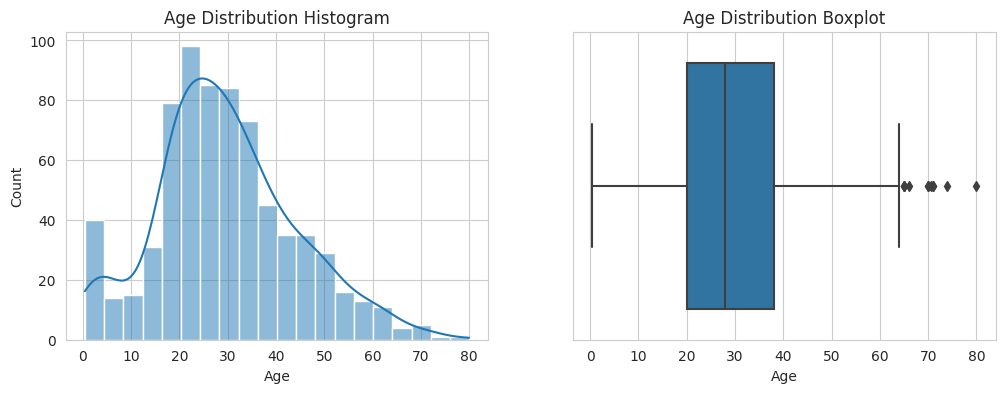

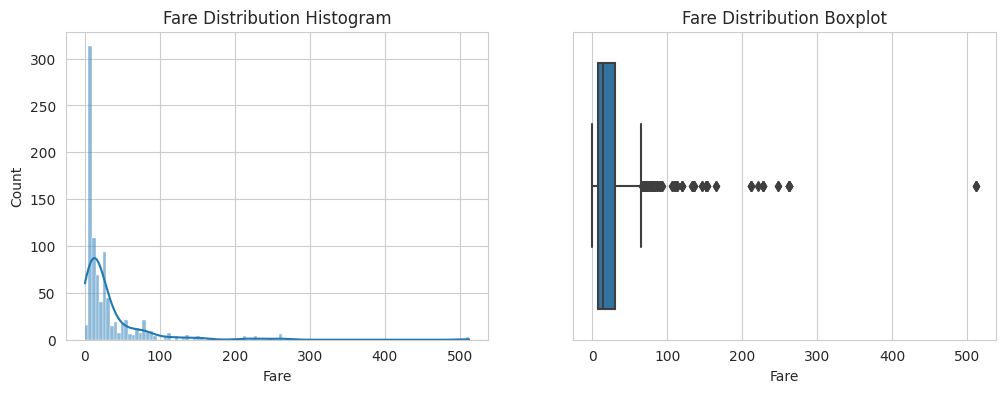

In [10]:
for var in num_var:
    num_dist(df_train, var)

Categorical

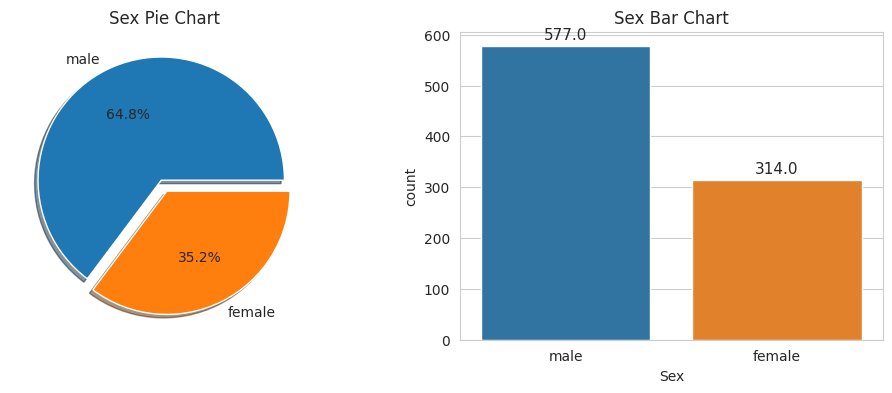

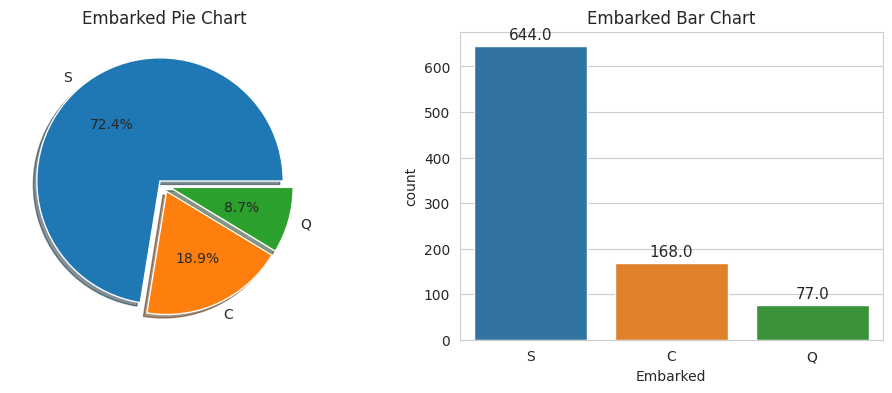

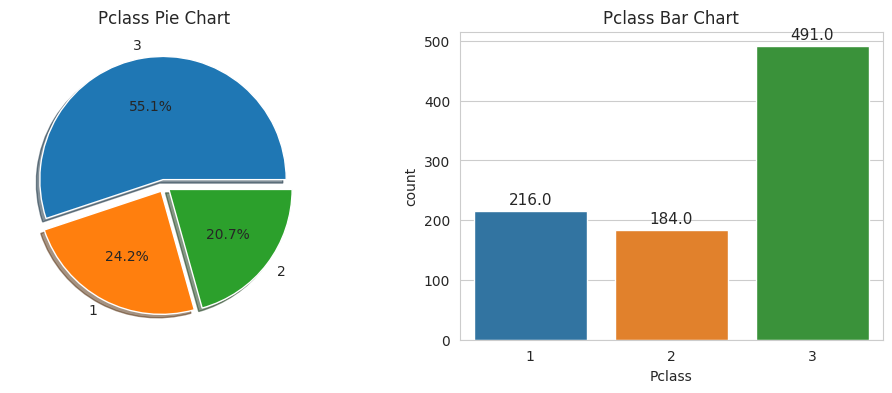

In [12]:
for var in cat_var:
    cat_dist(df_train, var)

Survived vs Not-Survived

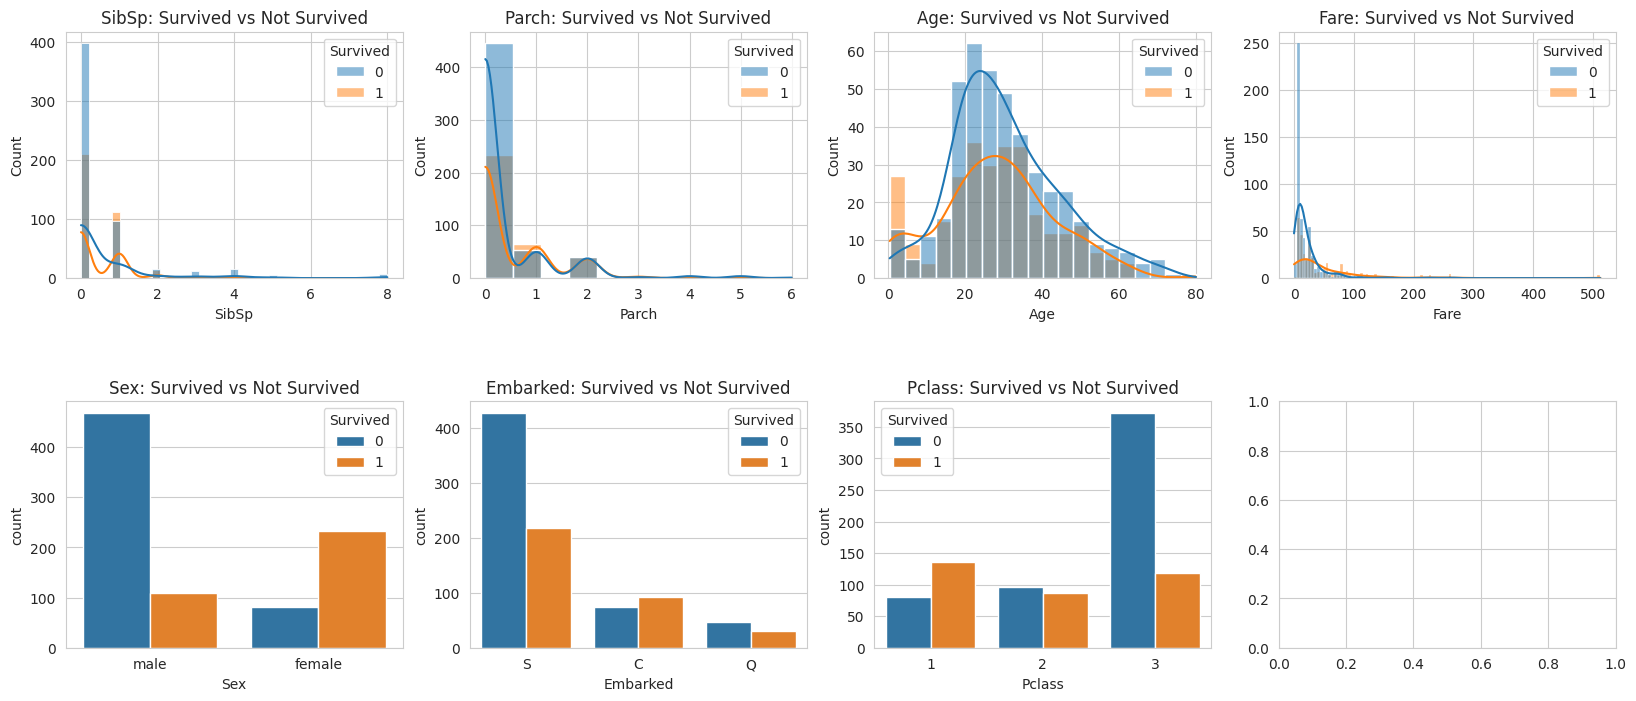

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.flatten()

for i, var in enumerate(num_var+cat_var):
    if i < 4:
        sns.histplot(data=df_train, x=var, hue=target, kde=True, ax=ax[i])
    else:
        sns.countplot(data=df_train, x=var, hue=target, ax=ax[i])

    ax[i].set_title(f"{var}: Survived vs Not Survived")

plt.subplots_adjust(hspace=0.5)
plt.show()

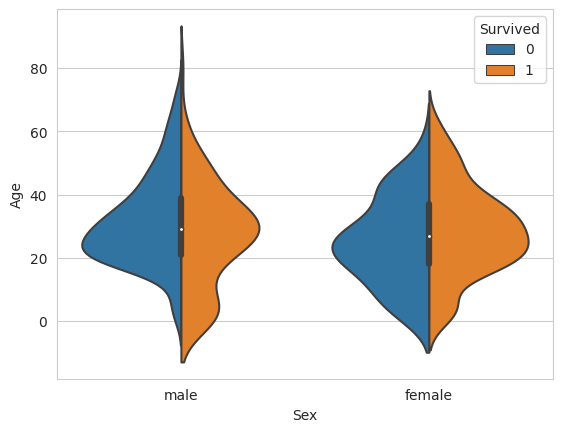

In [13]:
sns.violinplot(data=df_train, x="Sex", y="Age", hue="Survived", split=True)
plt.show()

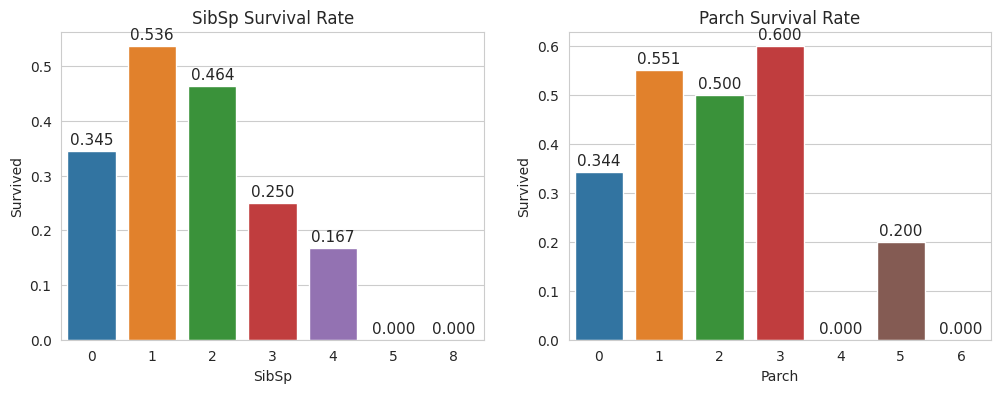

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, var in enumerate(["SibSp", "Parch"]):
    surv = sns.barplot(data=df_train, x=var, y=target, ax=ax[i], ci=None)
    for bar in surv.patches:
        surv.annotate(format("{:.3f}".format(bar.get_height())),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')

    ax[i].set_title(f"{var} Survival Rate")

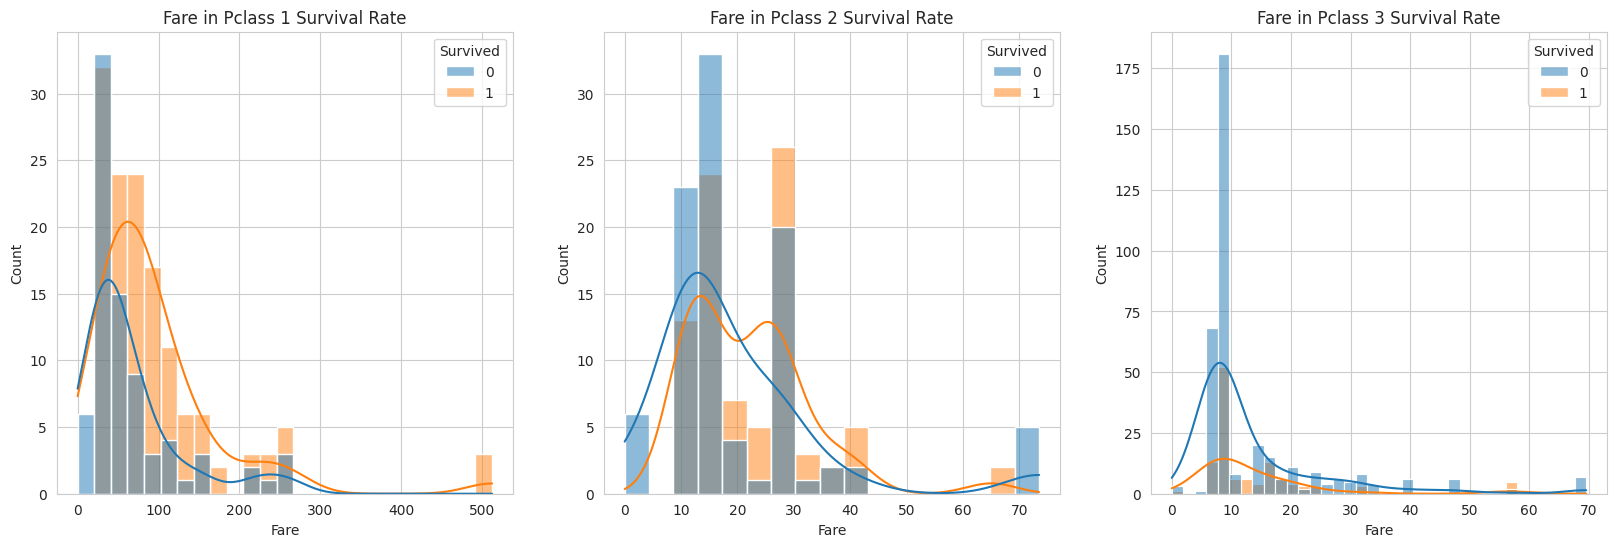

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, pc in enumerate(sorted(df_train["Pclass"].unique())):
    sns.histplot(data=df_train[df_train["Pclass"]==pc], x="Fare", hue=target, kde=True, ax=ax[i])
    ax[i].set_title(f"Fare in Pclass {pc} Survival Rate")

PassengerId

In [16]:
df_train["PassengerId"]

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

In [17]:
df_train.drop("PassengerId", axis=1, inplace=True)
df_test.drop("PassengerId", axis=1, inplace=True)

Names

In [18]:
df_train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [19]:
df_train["Title"] = df_train["Name"].str.extract('([A-Za-z]+)\.')
df_test["Title"] = df_test["Name"].str.extract('([A-Za-z]+)\.')

df_train["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [20]:
def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Other"

df_train["Title"] = df_train["Title"].map(convert_title)
df_test["Title"] = df_test["Title"].map(convert_title)

df_train["Title"].value_counts()

Mr        517
Miss      183
Mrs       126
Master     40
Other      25
Name: Title, dtype: int64

In [21]:
df_train.drop("Name", axis=1, inplace=True)
df_test.drop("Name", axis=1, inplace=True)

Ticket

In [22]:
df_train["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [23]:
df_train.drop("Ticket", axis=1, inplace=True)
df_test.drop("Ticket", axis=1, inplace=True)

Age

In [24]:
df_train.corr()["Age"].sort_values(ascending=False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

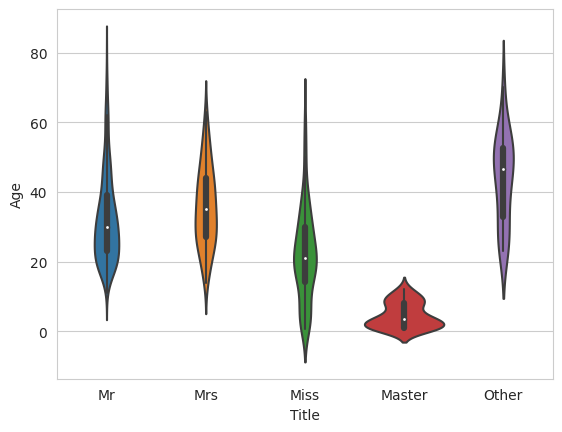

In [25]:
sns.violinplot(data=df_train, x="Title", y="Age")
plt.show()

In [26]:
df_train.groupby('Title')['Age'].mean()

Title
Master     4.574167
Miss      21.816327
Mr        32.368090
Mrs       35.788991
Other     43.750000
Name: Age, dtype: float64

In [27]:
data = [df_train, df_test]
for df in data:
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Master'), 'Age'] = 5
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Miss'), 'Age'] = 22
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Mr'), 'Age'] = 32
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Mrs'), 'Age'] = 36
    df.loc[(df["Age"].isnull()) & (df["Title"]=='Other'), 'Age'] = 44

Fare

In [28]:
df_train.corr()["Fare"].sort_values(ascending=False)

Fare        1.000000
Survived    0.257307
Parch       0.216225
SibSp       0.159651
Age         0.092122
Pclass     -0.549500
Name: Fare, dtype: float64

Choosing Best Algorithm

In [31]:
X_train = df_train.drop("Survived", axis=1)
y_train = df_train.Survived

X_test = df_test.copy()

In [35]:
df_test[df_test["Fare"].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
152,3,male,60.5,0,0,NaN,NaN,S,Mr


In [42]:
df_test.Fare.fillna(df_train.groupby("Pclass").mean()["Fare"][3], inplace=True)

In [37]:
data = [df_train, df_test]
for df in data:
    df['Relatives'] = df['SibSp'] + df['Parch']
    df.loc[df['Relatives'] > 0, 'Alone'] = 1
    df.loc[df['Relatives'] == 0, 'Alone'] = 0

In [38]:
df_train.drop(["SibSp", "Parch"], axis=1, inplace=True)
df_test.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [45]:
# df_train = pd.get_dummies(df_train, prefix=["Sex", "Embarked", "Title"])
# df_test = pd.get_dummies(df_test, prefix=["Sex", "Embarked", "Title"])

In [46]:
X_train = df_train.drop("Survived", axis=1)
y_train = df_train.Survived

X_test = df_test.copy()

**Conclusion** :
The Titanic classification model developed in this study demonstrates its effectiveness in predicting the survival outcomes of passengers aboard the Titanic. By employing various machine learning algorithms and features such as age, gender, and passenger class, the model achieved a high level of accuracy and performance.

The analysis revealed that certain factors played a significant role in determining survival chances. Women and children had higher survival rates compared to adult males. Passengers traveling in higher passenger classes also had better survival prospects. These findings align with historical records and support the notion of the "women and children first" principle during the Titanic disaster.

It is important to note that this classification model is based on the available dataset and its associated features. While the model demonstrates strong predictive capabilities, it may not account for all possible variables that could have influenced survival outcomes. Additional factors, such as individual actions, personal characteristics, and random events, could have impacted survival chances as well.

Overall, the Titanic classification model provides valuable insights into the factors contributing to survival on the Titanic. It serves as a useful tool for understanding historical events and can be applied to similar datasets to make predictions about passenger survival in other maritime disasters or emergency situations.
   